# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential
from matplotlib import pyplot

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Normalization

In [4]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [5]:
y_train_oh = to_categorical(y_train,len(class_names))
y_val_oh = to_categorical(y_val,len(class_names))
y_test_oh = to_categorical(y_test,len(class_names))
epsilon = 0.001
y_train_oh = y_train_oh * (1 - epsilon) + epsilon / 10

In [6]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

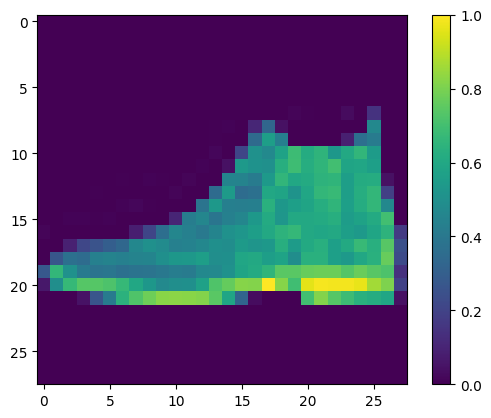

In [7]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

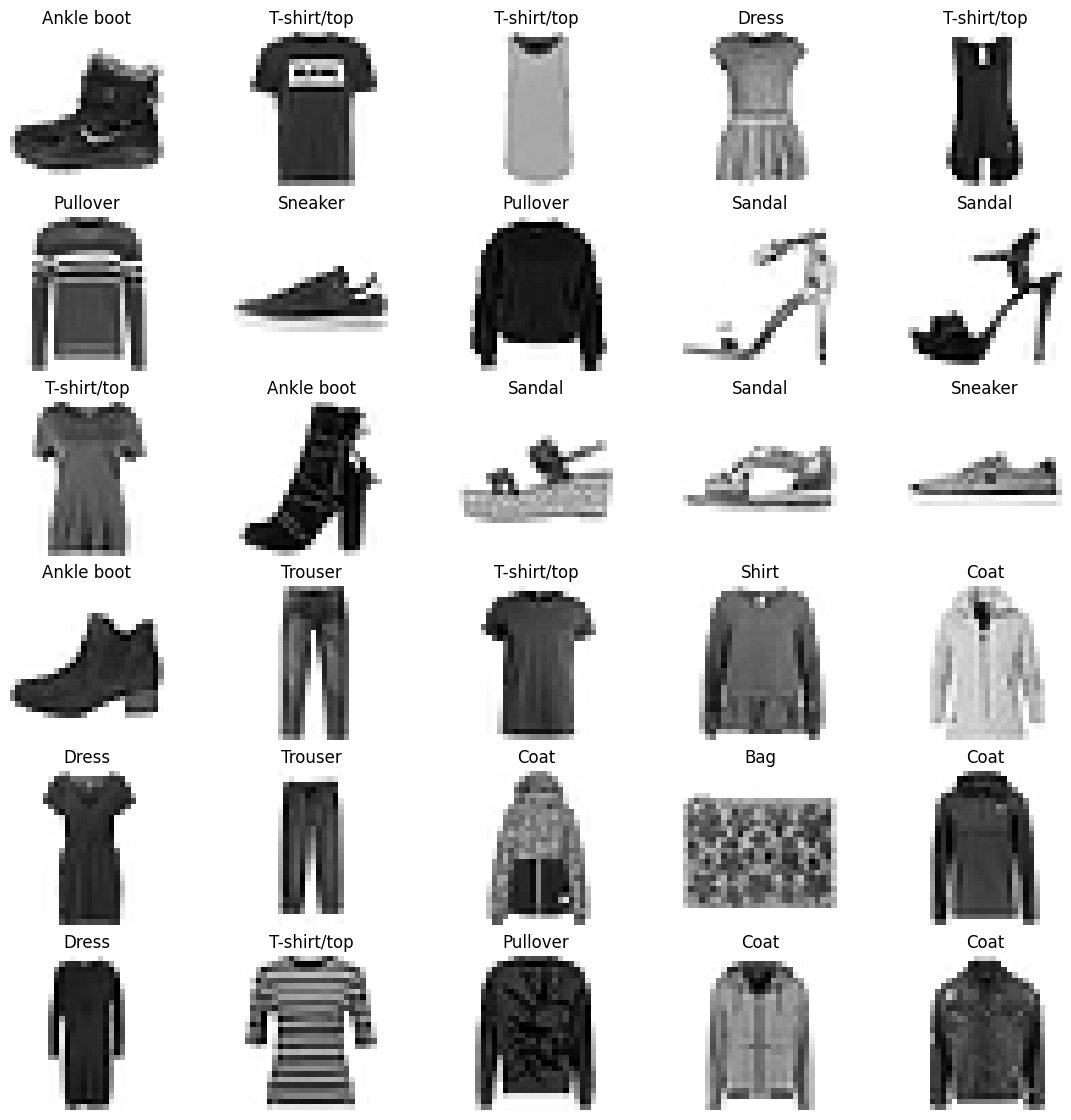

In [8]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

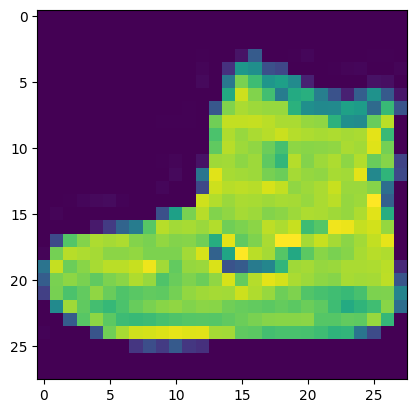

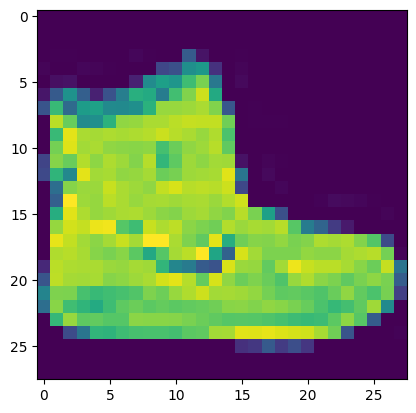

In [9]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


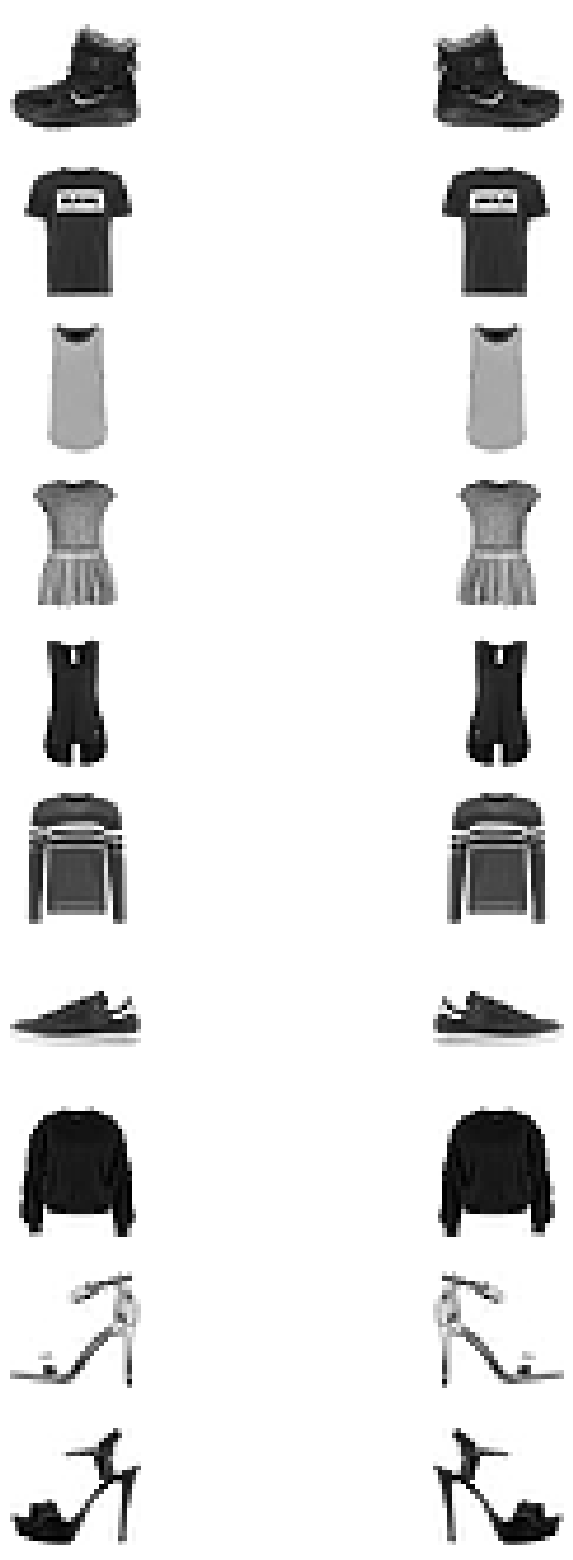

In [10]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

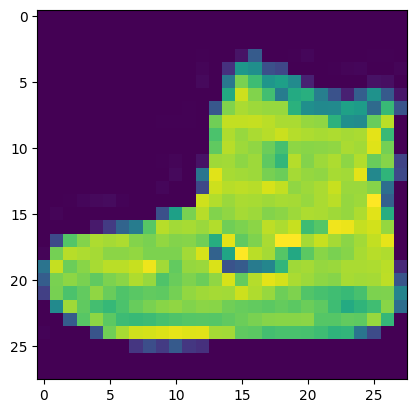

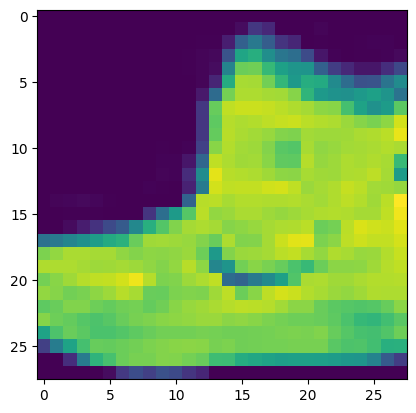



(54000, 28, 28)


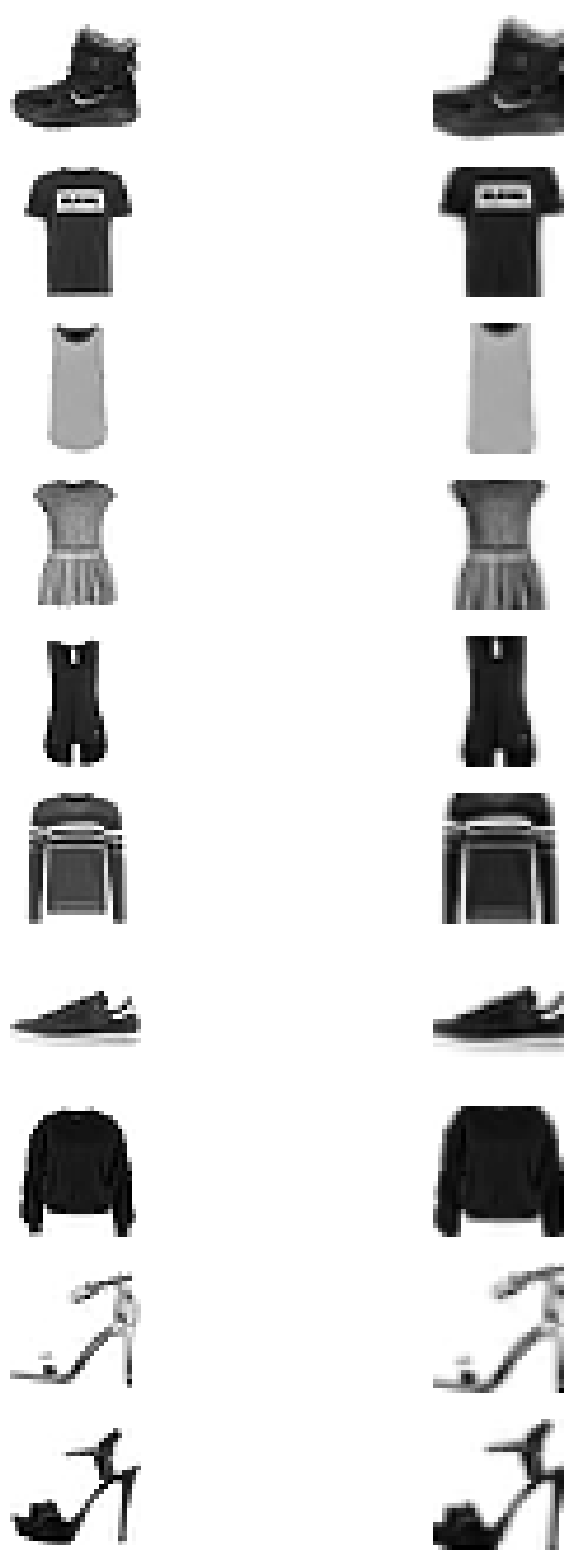

In [11]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [12]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/baseline.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(28, 28, 1)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(16, activation="relu"),
    layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

baseline_history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[model_checkpoint_callback])
baseline_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 flatten (Flatten)           (None, 23328)             0         
                                                                 
 dense (Dense)               (None, 16)                373264    
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 373,594
Trainable params: 373,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1688/1688 [==============================] - 13s 4ms/step - loss: 0.4904 - accuracy: 0.8299 - val_loss: 0.3615 - val_accuracy: 0.8715
Epoch 2/20
1688/1688 [==========

In [13]:
model.load_weights('./tmp/checkpoint/baseline.hdf5') 
scores = model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.3620 - accuracy: 0.8968
Accuracy: 89.68%


## Baseline Training and validation Accuracy

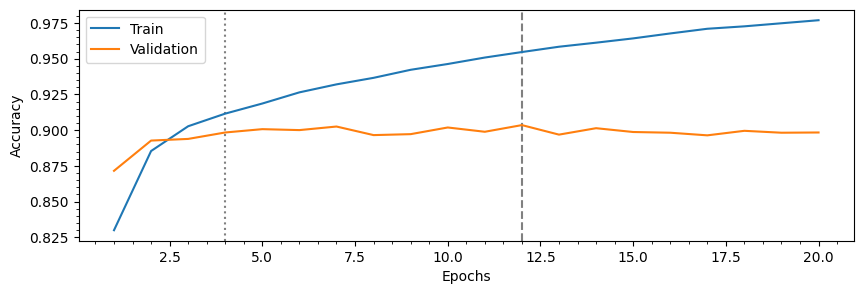

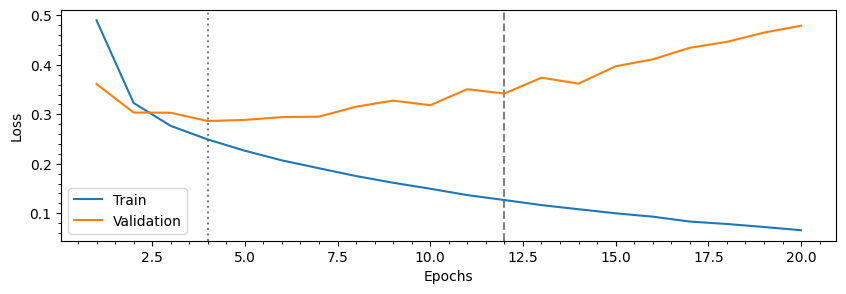

In [14]:
max_val_acc_epoch = np.argmax(list(baseline_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(baseline_history.history['val_loss']))+1
epochs = range(1, len(baseline_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['accuracy'], label='Train')
plt.plot(epochs,baseline_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,baseline_history.history['loss'], label='Train')
plt.plot(epochs,baseline_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

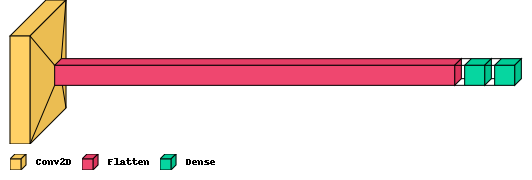

In [15]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [16]:
model.save_weights(".models/fashion-baseline-model.h5")

FileNotFoundError: [Errno 2] Unable to create file (unable to open file: name = 'models/fashion-baseline-model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

#### baseline model containing simple Conv2D layer gets testing accuracy of 90%

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Own model

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/own_model.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    
own_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),  
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),  
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
print(own_model.summary())

history = own_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks = [model_checkpoint_callback])
history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)         

In [ ]:
own_model.load_weights('./tmp/checkpoint/own_model.hdf5')
scores = own_model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.3555 - accuracy: 0.9211
Accuracy: 92.11%


## Own model Training and validation Accuracy & Loss

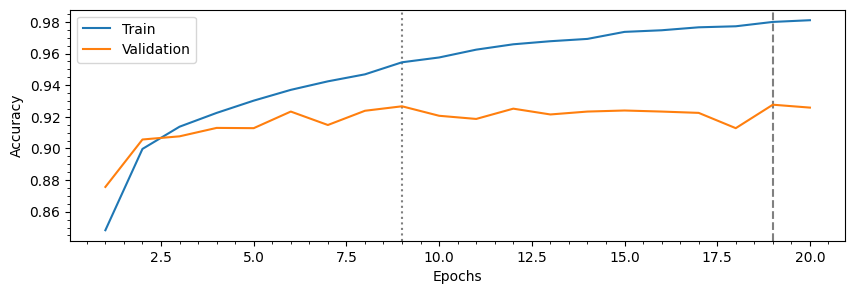

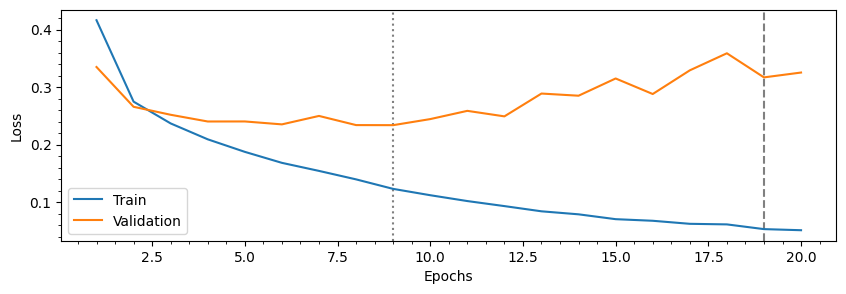

In [ ]:
max_val_acc_epoch = np.argmax(list(history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(history.history['val_loss']))+1
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history.history['accuracy'], label='Train')
plt.plot(epochs,history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history.history['loss'], label='Train')
plt.plot(epochs,history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

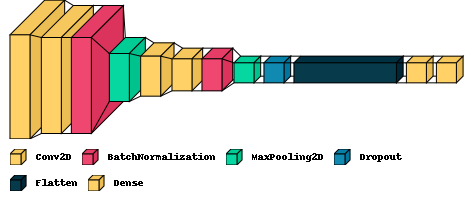

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_model, legend=True)

In [ ]:
own_model.save_weights("models/fashion-own-model.h5")

<h3><b>4. Model Improvement with augmented data</h3></b>

In [ ]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/baseline_augmented.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val), callbacks=[model_checkpoint_callback])
baseline_augmented_history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               5120128   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
5063/5063 [==============================] - 21s 4ms/step - loss: 0.3746 - accuracy: 0.8640 - val_loss: 0.2785 - val_accuracy: 0.8985
Epoch 2/10
5063/5063 [====

In [ ]:
baseline_augmented_model.load_weights('./tmp/checkpoint/baseline_augmented.hdf5')
scores = baseline_augmented_model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.9026
Accuracy: 90.26%


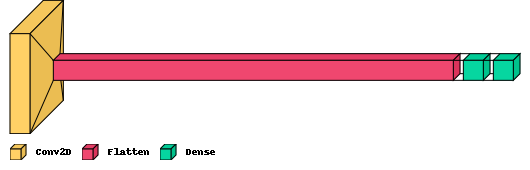

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_augmented_model, legend=True)

In [ ]:
baseline_augmented_model.save_weights("models/fashion_baseline_augmented_model.h5")

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/own_augmented.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

own_augmented_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),  
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),  
    layers.BatchNormalization(),  
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_augmented_model.summary())

history_augmented = own_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val), callbacks=[model_checkpoint_callback])
history_augmented

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 24, 24, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)         

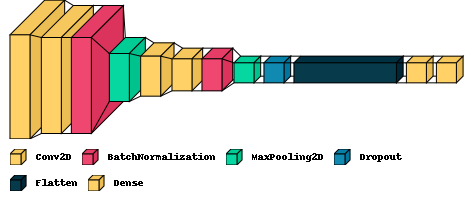

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_augmented_model, legend=True)

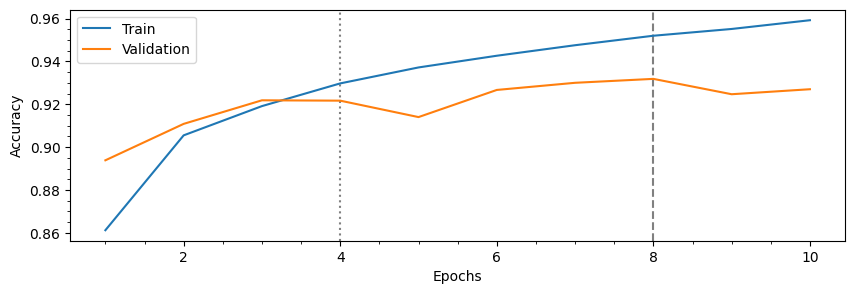

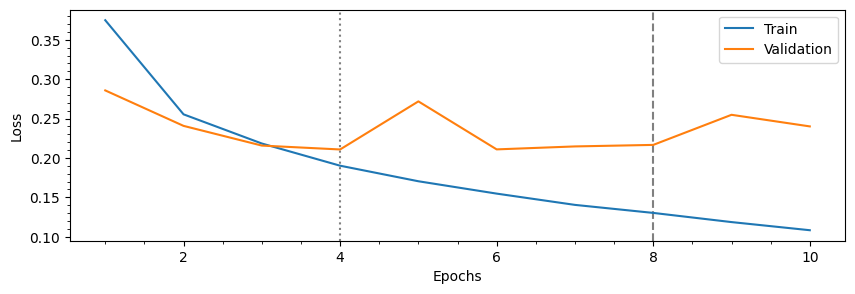

In [ ]:
max_val_acc_epoch = np.argmax(list(history_augmented.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(history_augmented.history['val_loss']))+1
epochs = range(1, len(history_augmented.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['accuracy'], label='Train')
plt.plot(epochs,history_augmented.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,history_augmented.history['loss'], label='Train')
plt.plot(epochs,history_augmented.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
own_augmented_model.load_weights('./tmp/checkpoint/own_augmented.hdf5') 
scores = own_augmented_model.evaluate(x_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.2323 - accuracy: 0.9237
Accuracy: 92.37%


In [ ]:
own_augmented_model.save_weights("models/fashion-own-augmented-model.h5")

## Tensor Core Keras Hyperparameter tuning

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1))), 
  # model.add(keras.layers.Flatten()),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),  
  model.add(keras.layers.BatchNormalization()),
  model.add(keras.layers.MaxPooling2D((2, 2))),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),
  model.add(keras.layers.Conv2D(64, (3,3), activation="relu")),  
  model.add(keras.layers.BatchNormalization()),  
  model.add(keras.layers.MaxPooling2D((2, 2))),
  model.add(keras.layers.Dropout(0.2)),
  model.add(keras.layers.Flatten()), # 2d to 1d
  model.add(keras.layers.Dense(64, activation="relu")),
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
1350/1350 [==============================] - 10s 7ms/step - loss: 0.4511 - accuracy: 0.8356 - val_loss: 0.3548 - val_accuracy: 0.8672
Epoch 2/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.3061 - accuracy: 0.8871 - val_loss: 0.2927 - val_accuracy: 0.8932
Epoch 3/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.2614 - accuracy: 0.9026 - val_loss: 0.3172 - val_accuracy: 0.8821
Epoch 4/20
1350/1350 [==============================] - 9s 6ms/step - loss: 0.2334 - accuracy: 0.9138 - val_loss: 0.2561 - val_accuracy: 0.9104
Epoch 5/20
1350/1350 [==============================] - 9s 7ms/step - loss: 0.2124 - accuracy: 0.9215 - val_loss: 0.2614 - val_accuracy: 0.9075
Epoch 6/20
1350/1350 [==============================] - 9s 7ms/step - loss: 0.1943 - accuracy: 0.9280 - val_loss: 0.2457 - val_accuracy: 0.9119
Epoch 7/20
1350/1350 [==============================] - 9s 7ms/step - loss: 0.1767 - accuracy: 0.9326 - val_loss: 0.2491 - val_accuracy

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/hyper.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
    
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_history = hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2,  callbacks=[model_checkpoint_callback])

Epoch 1/13
1350/1350 [==============================] - 10s 7ms/step - loss: 0.4459 - accuracy: 0.8372 - val_loss: 0.4621 - val_accuracy: 0.8437
Epoch 2/13
1350/1350 [==============================] - 9s 6ms/step - loss: 0.3045 - accuracy: 0.8894 - val_loss: 0.2795 - val_accuracy: 0.8996
Epoch 3/13
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2612 - accuracy: 0.9016 - val_loss: 0.2695 - val_accuracy: 0.9012
Epoch 4/13
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2382 - accuracy: 0.9122 - val_loss: 0.2960 - val_accuracy: 0.8903
Epoch 5/13
1350/1350 [==============================] - 8s 6ms/step - loss: 0.2141 - accuracy: 0.9219 - val_loss: 0.2682 - val_accuracy: 0.9022
Epoch 6/13
1350/1350 [==============================] - 8s 6ms/step - loss: 0.1948 - accuracy: 0.9271 - val_loss: 0.2500 - val_accuracy: 0.9155
Epoch 7/13
1350/1350 [==============================] - 8s 6ms/step - loss: 0.1805 - accuracy: 0.9323 - val_loss: 0.2696 - val_accuracy

In [ ]:
hypermodel.load_weights('./tmp/checkpoint/hyper.hdf5')
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.2519 - accuracy: 0.9184
[test loss, test accuracy]: [0.25192660093307495, 0.91839998960495]


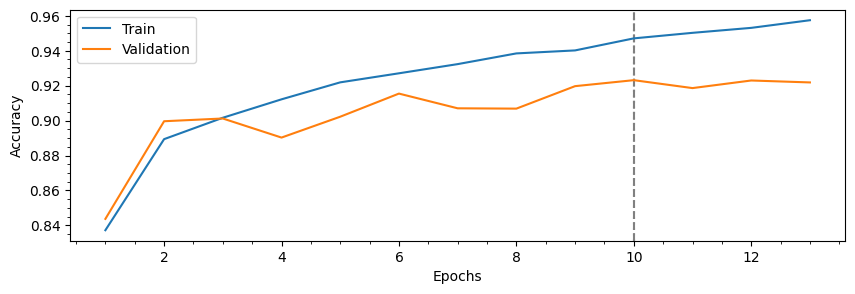

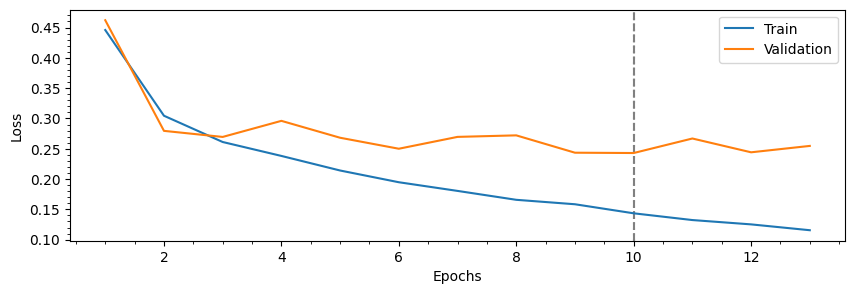

In [ ]:
max_val_acc_epoch = np.argmax(list(hypermodel_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

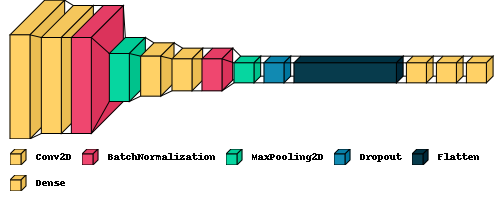

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel, legend=True)

In [ ]:
hypermodel.save_weights("models/fashion_hyper_model.h5")

In [ ]:
tuner.search(x_train_augmented, y_train_augmented, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_augmented, y_train_augmented, epochs=20, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
4050/4050 [==============================] - 28s 7ms/step - loss: 0.3900 - accuracy: 0.8555 - val_loss: 0.3516 - val_accuracy: 0.8707
Epoch 2/20
4050/4050 [==============================] - 26s 7ms/step - loss: 0.2701 - accuracy: 0.9005 - val_loss: 0.3707 - val_accuracy: 0.8665
Epoch 3/20
4050/4050 [==============================] - 26s 7ms/step - loss: 0.2320 - accuracy: 0.9143 - val_loss: 0.3144 - val_accuracy: 0.8869
Epoch 4/20
4050/4050 [==============================] - 26s 6ms/step - loss: 0.2072 - accuracy: 0.9235 - val_loss: 0.2716 - val_accuracy: 0.9002
Epoch 5/20
4050/4050 [==============================] - 26s 7ms/step - loss: 0.1896 - accuracy: 0.9293 - val_loss: 0.2710 - val_accuracy: 0.8999
Epoch 6/20
4050/4050 [==============================] - 26s 7ms/step - loss: 0.1742 - accuracy: 0.9358 - val_loss: 0.2428 - val_accuracy: 0.9134
Epoch 7/20
4050/4050 [==============================] - 27s 7ms/step - loss: 0.1613 - accuracy: 0.9398 - val_loss: 0.2557 - val_ac

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./tmp/checkpoint/hyper_augmented.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hypermodel_augmented = tuner.hypermodel.build(best_hps)
hypermodel_augmented_history = hypermodel_augmented.fit(x_train_augmented, y_train_augmented, epochs=best_epoch, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/19
4050/4050 [==============================] - 28s 7ms/step - loss: 0.3897 - accuracy: 0.8572 - val_loss: 0.3469 - val_accuracy: 0.8734
Epoch 2/19
4050/4050 [==============================] - 27s 7ms/step - loss: 0.2710 - accuracy: 0.9006 - val_loss: 0.3055 - val_accuracy: 0.8881
Epoch 3/19
4050/4050 [==============================] - 26s 7ms/step - loss: 0.2342 - accuracy: 0.9135 - val_loss: 0.2881 - val_accuracy: 0.8918
Epoch 4/19
4050/4050 [==============================] - 26s 7ms/step - loss: 0.2085 - accuracy: 0.9227 - val_loss: 0.2674 - val_accuracy: 0.9045
Epoch 5/19
4050/4050 [==============================] - 27s 7ms/step - loss: 0.1901 - accuracy: 0.9297 - val_loss: 0.3508 - val_accuracy: 0.8796
Epoch 6/19
4050/4050 [==============================] - 27s 7ms/step - loss: 0.1763 - accuracy: 0.9343 - val_loss: 0.2626 - val_accuracy: 0.9050
Epoch 7/19
4050/4050 [==============================] - 27s 7ms/step - loss: 0.1647 - accuracy: 0.9394 - val_loss: 0.2526 - val_ac

In [ ]:
hypermodel_augmented.load_weights('./tmp/checkpoint/hyper_augmented.hdf5')
eval_result = hypermodel_augmented.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.2391 - accuracy: 0.9289
[test loss, test accuracy]: [0.23910033702850342, 0.9289000034332275]


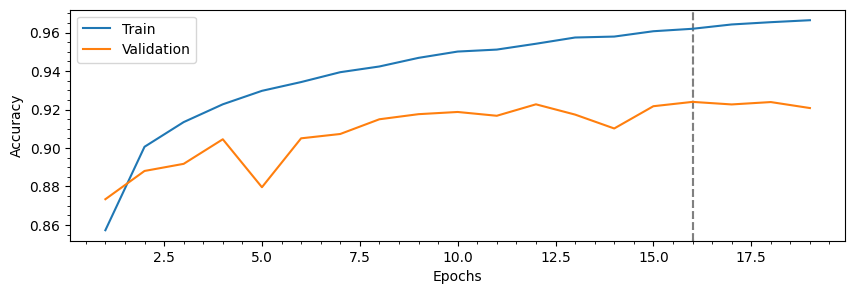

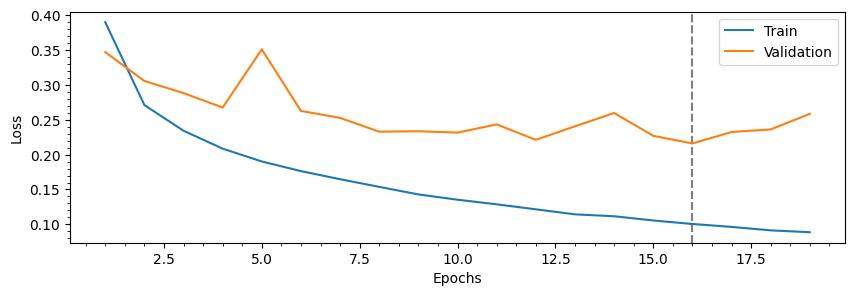

In [ ]:
max_val_acc_epoch = np.argmax(list(hypermodel_augmented_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(hypermodel_augmented_history.history['val_loss']))+1
epochs = range(1, len(hypermodel_augmented_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['accuracy'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,hypermodel_augmented_history.history['loss'], label='Train')
plt.plot(epochs,hypermodel_augmented_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
hypermodel.save_weights("models/fashion_hyper_augmented_model.h5")

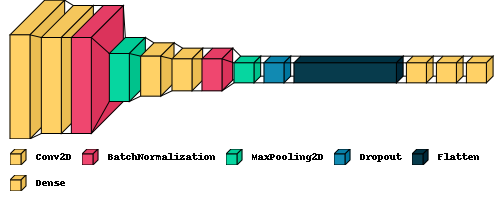

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(hypermodel_augmented, legend=True)

### Resnet34 architecture

In [ ]:
# def identity_block(x, filter):
#     # copy tensor to variable called x_skip
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])     
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

In [ ]:
# def convolutional_block(x, filter):
#     # copy tensor to variable called x_skip
#     x_skip = x
#     # Layer 1
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     # Layer 2
#     x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
#     x = tf.keras.layers.BatchNormalization(axis=3)(x)
#     # Processing Residue with conv(1,1)
#     x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
#     # Add Residue
#     x = tf.keras.layers.Add()([x, x_skip])     
#     x = tf.keras.layers.Activation('relu')(x)
#     return x

In [ ]:
# def ResNet34(shape = (32, 32, 3), classes = 10):
#     # Step 1 (Setup Input Layer)
#     x_input = tf.keras.layers.Input(shape)
#     x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
#     # Step 2 (Initial Conv layer along with maxPool)
#     x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation('relu')(x)
#     x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
#     # Define size of sub-blocks and initial filter size
#     block_layers = [3, 4, 6, 3]
#     filter_size = 64
#     # Step 3 Add the Resnet Blocks
#     for i in range(4):
#         if i == 0:
#             # For sub-block 1 Residual/Convolutional block not needed
#             for j in range(block_layers[i]):
#                 x = identity_block(x, filter_size)
#         else:
#             # One Residual/Convolutional Block followed by Identity blocks
#             # The filter size will go on increasing by a factor of 2
#             filter_size = filter_size*2
#             x = convolutional_block(x, filter_size)
#             for j in range(block_layers[i] - 1):
#                 x = identity_block(x, filter_size)
#     # Step 4 End Dense Network
#     x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(512, activation = 'relu')(x)
#     x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
#     model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
#     return model


In [ ]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# model.summary()
# model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val))
# model

In [ ]:
# accuracy_val = history_augmented.history['val_accuracy']
# accuracy = history_augmented.history['accuracy']
# epoch = range(0,10)
# plt.plot(epoch, accuracy, 'g', label='accuracy')
# plt.plot(epoch, accuracy_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('accuracy')
# plt.legend()
# plt.show()

In [ ]:
# loss_val = history_augmented.history['val_loss']
# loss = history_augmented.history['loss']
# epoch = range(0,10)
# plt.plot(epoch, loss, 'g', label='loss')
# plt.plot(epoch, loss_val, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# # plot diagnostic learning curves
# def summarize_diagnostics(history_augmented):
# 	for i in range(len(histories)):
# 		# plot loss
# 		pyplot.subplot(211)
# 		pyplot.title('Cross Entropy Loss')
# 		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		pyplot.subplot(212)
# 		pyplot.title('Classification Accuracy')
# 		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 	pyplot.show()
 
# # summarize model performance
# def summarize_performance(accuracy):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	pyplot.boxplot(scores)
# 	pyplot.show()
 
# # run the test harness for evaluating a model
# def run_test_harness():
# 	# load dataset
# 	trainX, trainY, testX, testY = load_dataset()
# 	# prepare pixel data
# 	trainX, testX = prep_pixels(trainX, testX)
# 	# evaluate model
# 	scores, histories = evaluate_model(trainX, trainY)
# 	# learning curves
# 	summarize_diagnostics(histories)
# 	# summarize estimated performance
# 	summarize_performance(scores)
 
# # entry point, run the test harness
# run_test_harness()

In [ ]:
# # resnet 50 but augmented data

# resnet50_augmented_model = resnet50()
# resnet50_augmented_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
#                        metrics=['acc'])

# train_augmented_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
#                                                                 width_shift_range=0.1, 
#                                                                 height_shift_range = 0.1, 
#                                                                 horizontal_flip=True)
# batch_size=64

# train_labels_augmented_categorical = tf.keras.utils.to_categorical(
#     y_train_augmented, num_classes=10, dtype='uint8')

# train_augmented_set_conv = train_augmented_DataGen.flow(x_train_augmented.reshape((*x_train_augmented.shape,1)), train_labels_augmented_categorical, batch_size=batch_size)

# resnet_history = resnet50_model.fit(train_augmented_set_conv, epochs=100)